<a href="https://colab.research.google.com/github/alfianprabowo25/capstone/blob/main/capsrtone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

ModuleNotFoundError: No module named 'streamlit'

In [ ]:
df = pd.read_csv('./ObesityDataSet.csv')

In [ ]:
print(df.head())

In [ ]:
print(df.info())

In [ ]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

In [ ]:
unique_values = df.nunique()
print("Unique values per column:")
print(unique_values)

In [ ]:
duplicate_rows = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}")

In [ ]:
print(df['NObeyesdad'].value_counts())

In [ ]:
df['Height'] = pd.to_numeric(df['Height'], errors='coerce')
df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')


In [ ]:
print("\nVisualizing the distribution of Height and Weight:")
df_numeric = df[['Height', 'Weight']]
df_numeric.hist(bins=20, figsize=(15,10))
plt.suptitle('Distribution of Height and Weight')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df_numeric)
plt.title('Boxplot of Numerical Features')
plt.show()

In [ ]:
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

In [ ]:
# Mengisi missing values dengan median
df['Height'] = df['Height'].fillna(df['Height'].median())
df['Weight'] = df['Weight'].fillna(df['Weight'].median())
df['Age'] = df['Age'].fillna(df['Age'].median())


In [78]:
# Mengisi missing values pada kolom kategorikal dengan modus tanpa menggunakan inplace=True
categorical_cols = ['Gender', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # Mengisi missing values dengan modus kolom


In [79]:
df.drop_duplicates(inplace=True)

In [80]:
# 3. Tangani Outliers menggunakan IQR (Interquartile Range)
# Menghitung IQR untuk kolom numerik
Q1 = df[['Height', 'Weight']].quantile(0.25)
Q3 = df[['Height', 'Weight']].quantile(0.75)
IQR = Q3 - Q1

In [81]:
df = df[~((df[['Height', 'Weight']] < (Q1 - 1.5 * IQR)) | (df[['Height', 'Weight']] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [82]:
# 4. Ubah Data Kategori menjadi Numerik (Label Encoding untuk kolom kategorikal)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [83]:

# Tentukan fitur numerik dan target
features = df.drop('NObeyesdad', axis=1)  # Menghapus kolom target dari fitur
target = df['NObeyesdad']

In [84]:
# Memeriksa distribusi kelas target
class_counts = target.value_counts()
print(f"Class distribution before balancing: {class_counts}")

Class distribution before balancing: NObeyesdad
2    349
4    319
3    295
6    286
1    282
5    270
0    265
Name: count, dtype: int64


In [85]:
# Oversample kelas minoritas menggunakan upsampling
df_majority = df[df['NObeyesdad'] == 0]
df_minority = df[df['NObeyesdad'] == 1]

In [86]:
# Memeriksa distribusi kelas pada kolom 'NObeyesdad'
class_counts = target.value_counts()
print(f"Class distribution before balancing: {class_counts}")



Class distribution before balancing: NObeyesdad
2    349
4    319
3    295
6    286
1    282
5    270
0    265
Name: count, dtype: int64


In [87]:
# Memeriksa distribusi kelas pada kolom 'NObeyesdad'
class_counts = df['NObeyesdad'].value_counts()
print(f"Class distribution before balancing: {class_counts}")

# Jika jumlah kelas mayoritas atau minoritas ternyata 0, tampilkan pesan
if class_counts.min() == 0:
    print("Error: One of the classes is missing. Please check the distribution of 'NObeyesdad'.")
else:
    # Memisahkan kelas mayoritas dan minoritas berdasarkan nilai pada 'NObeyesdad'
    df_majority = df[df['NObeyesdad'] == class_counts.idxmax()]  # Kelas mayoritas (yang paling banyak)
    df_minority = df[df['NObeyesdad'] == class_counts.idxmin()]  # Kelas minoritas (yang paling sedikit)

    # Menyeimbangkan dataset menggunakan oversampling untuk kelas minoritas
    df_minority_upsampled = resample(df_minority,
                                     replace=True,  # Sampling dengan penggantian
                                     n_samples=len(df_majority),  # Menyamakan jumlah dengan kelas mayoritas
                                     random_state=42)

    # Menggabungkan kembali data mayoritas dan minoritas yang sudah di-oversample
    df_balanced = pd.concat([df_majority, df_minority_upsampled])

    # Memisahkan fitur dan target dari data yang sudah di-balance
    features_balanced = df_balanced.drop('NObeyesdad', axis=1)
    target_balanced = df_balanced['NObeyesdad']

    # Memeriksa distribusi kelas setelah balancing
    balanced_class_counts = target_balanced.value_counts()
    print(f"Class distribution after balancing: {balanced_class_counts}")


Class distribution before balancing: NObeyesdad
2    349
4    319
3    295
6    286
1    282
5    270
0    265
Name: count, dtype: int64
Class distribution after balancing: NObeyesdad
2    349
0    349
Name: count, dtype: int64


In [88]:
# Normalisasi atau Standarisasi Data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_balanced)

In [89]:
print("\nFirst few rows of scaled features:")
print(features_scaled[:5])


First few rows of scaled features:
[[ 0.35389499  1.08484566  1.62265616  1.45310857 -0.66820636  0.31901339
   1.35626756  0.46286955 -0.2301157  -0.02394566  1.64332299  0.60277467
   1.08338564  1.40782705 -1.55743536  0.56756249]
 [ 2.2266376   1.08484566  1.10805899  1.19243142 -2.36423559  0.31901339
  -0.88323725  0.46286955 -0.2301157  -0.02394566 -0.12485113 -1.63518662
   1.08338564  0.72562718  0.53715015 -1.71796801]
 [ 0.72844351 -0.86174116 -1.67076578  0.2800614   1.02782287  0.31901339
  -0.88323725 -1.98203796 -0.2301157  -0.02394566 -0.12485113 -1.63518662
  -1.4437919  -1.24410486  0.53715015 -1.71796801]
 [ 3.59998219 -0.86174116 -0.02405481  0.67107712  1.02782287  0.31901339
   1.35626756 -1.98203796 -0.2301157   8.33308868 -0.12485113  0.60277467
  -1.4437919  -1.24410486  0.53715015 -1.71796801]
 [ 8.06613407 -0.86174116 -0.95032973  0.45384617 -0.66820636  0.31901339
  -1.46900884 -1.98203796 -0.2301157  -0.02394566 -0.12485113  0.60277467
  -1.4437919   1.407

In [90]:
#  Encode Fitur Kategorikal ===
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [91]:
# Split Fitur dan Target ===
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

In [92]:
# Normalisasi Data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [93]:
# Split Train-Test ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [94]:
#  Inisialisasi Model ===
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier()
}

In [95]:
#  Evaluasi Model ===
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }


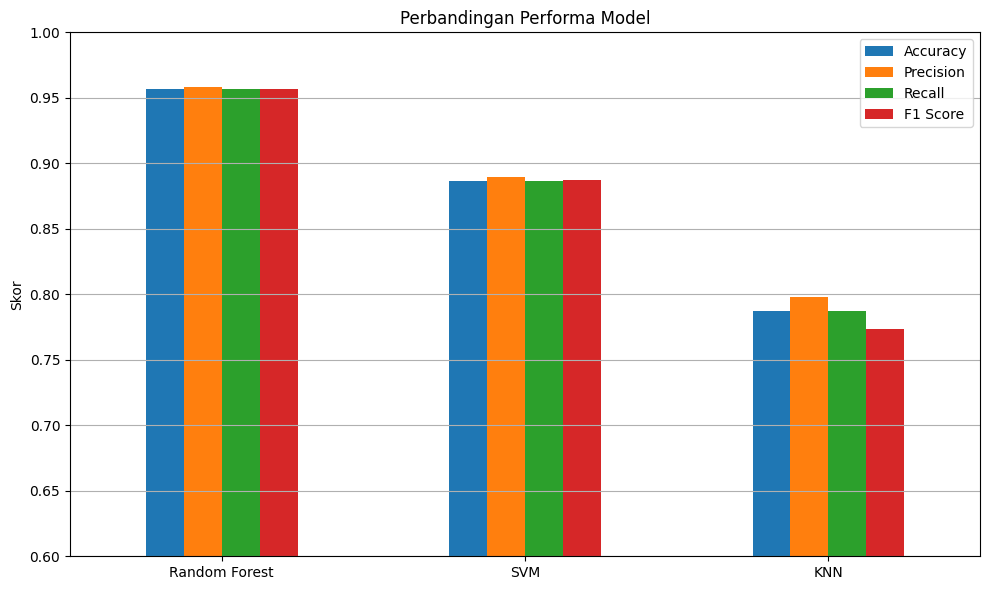

In [96]:
# Visualisasi Perbandingan Metrik ===
metrics_df = pd.DataFrame(results).T[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Perbandingan Performa Model')
plt.ylabel('Skor')
plt.xticks(rotation=0)
plt.ylim(0.6, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [97]:

#  Kesimpulan Otomatis ===
best_model = metrics_df['F1 Score'].idxmax()
print(f"🔍 Model terbaik berdasarkan F1 Score adalah: **{best_model}** dengan F1 Score sebesar {metrics_df.loc[best_model, 'F1 Score']:.4f}")


🔍 Model terbaik berdasarkan F1 Score adalah: **Random Forest** dengan F1 Score sebesar 0.9569


In [98]:
#  Definisikan Parameter Tuning ===
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}


In [99]:
#  Inisialisasi Model Awal ===
base_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier()
}


In [100]:
#  Hyperparameter Tuning & Evaluasi ===
tuned_results = {}
best_models = {}

for name in base_models:
    print(f"Tuning {name}...")
    grid = GridSearchCV(base_models[name], param_grids[name], cv=3, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    tuned_results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

print("✅ Hyperparameter tuning selesai.")

Tuning Random Forest...
Tuning SVM...
Tuning KNN...
✅ Hyperparameter tuning selesai.


In [ ]:
#  Visualisasi Confusion Matrix Setelah Tuning ===
for name, res in tuned_results.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(res["Confusion Matrix"], annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix (Tuned) - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
#  Visualisasi Perbandingan Kinerja Sebelum vs Sesudah Tuning ===
before_df = pd.DataFrame(results).T[['Accuracy', 'Precision', 'Recall', 'F1 Score']].rename(columns=lambda x: f'{x} (Before)')
after_df = pd.DataFrame(tuned_results).T[['Accuracy', 'Precision', 'Recall', 'F1 Score']].rename(columns=lambda x: f'{x} (After)')

comparison_df = pd.concat([before_df, after_df], axis=1)
comparison_df.plot(kind='bar', figsize=(12, 7))
plt.title('Perbandingan Performa Sebelum & Sesudah Tuning')
plt.ylabel('Skor')
plt.xticks(rotation=0)
plt.ylim(0.6, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Kesimpulan Otomatis ===
improvement = (after_df['F1 Score (After)'] - before_df['F1 Score (Before)']).sort_values(ascending=False)
print("📈 Peningkatan F1 Score setelah tuning:")
print(improvement)

best_tuned = after_df['F1 Score (After)'].idxmax()
print(f"\n🔍 Model terbaik setelah tuning: **{best_tuned}** dengan F1 Score {after_df.loc[best_tuned, 'F1 Score (After)']:.4f}")


In [ ]:
# Load model dan scaler
model = joblib.load("best_model.pkl")  # Model hasil training & tuning
scaler = joblib.load("scaler.pkl")     # Scaler dari training data